In [1]:
import pandas as pd  # data manipulation
import numpy as np   # numerical operations
import matplotlib.pyplot as plt  # plotting
import seaborn as sns            # enhanced visualizations
import warnings
import os
warnings.filterwarnings('ignore')  # hide warnings

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load datasets
train = pd.read_csv('Data/train.csv', parse_dates=['date'])  # train data with sales
test = pd.read_csv('Data/test.csv', parse_dates=['date'])    # test data to predict
oil = pd.read_csv('Data/oil.csv', parse_dates=['date'])      # daily oil prices
holidays = pd.read_csv('Data/holidays_events.csv', parse_dates=['date'])  # holidays/events
stores = pd.read_csv('Data/stores.csv')                     # store info
transactions = pd.read_csv('Data/transactions.csv', parse_dates=['date'])  # daily transactions

# Quick check of dataset shapes
print("Dataset Shapes:")
print(f"Train:        {train.shape}")
print(f"Test:         {test.shape}")
print(f"Oil:          {oil.shape}")
print(f"Holidays:     {holidays.shape}")
print(f"Stores:       {stores.shape}")
print(f"Transactions: {transactions.shape}")


Dataset Shapes:
Train:        (3000888, 6)
Test:         (28512, 5)
Oil:          (1218, 2)
Holidays:     (350, 6)
Stores:       (54, 5)
Transactions: (83488, 3)


In [2]:
# Inspect train dataset: view sample, types, missing values, and stats
print("\n=== Train Dataset Info ===")
print(train.head())

# Check the data types of each column
print("\nData Types:")
print(train.dtypes)

# Count missing values per column
print("\nMissing Values:")
print(train.isnull().sum())

# Display basic statistics for numerical columns
print("\nBasic Statistics:")
print(train.describe())



=== Train Dataset Info ===
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

Data Types:
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

Missing Values:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Basic Statistics:
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00

In [3]:
# Inspect other datasets: get a quick look at their contents and missing values

print("\n=== Stores Dataset ===")
print(stores.head())  # store info: city, state, type, cluster

print("\n=== Oil Dataset ===")
print(oil.head())  # daily oil prices
print(f"Missing oil prices: {oil['dcoilwtico'].isnull().sum()}")  # check missing values

print("\n=== Holidays Dataset ===")
print(holidays.head())  # holidays and special events

print("\n=== Transactions Dataset ===")
print(transactions.head())  # daily transactions per store



=== Stores Dataset ===
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

=== Oil Dataset ===
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
Missing oil prices: 43

=== Holidays Dataset ===
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   


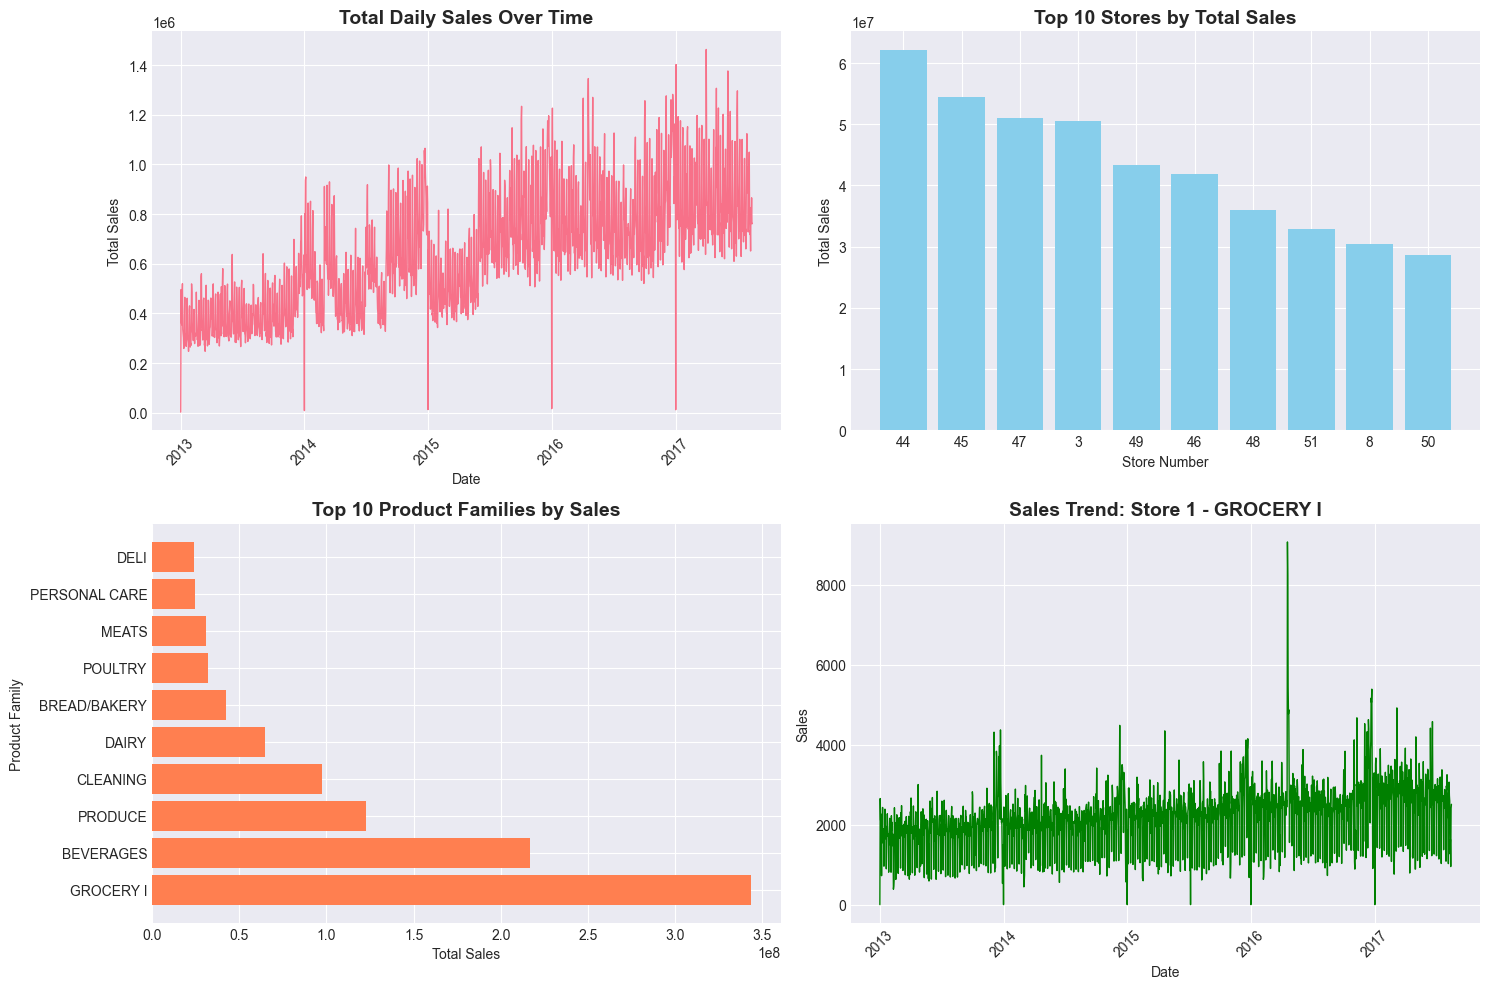

In [4]:
# Visualize sales trends for sample stores and product families
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Total daily sales over time
daily_sales = train.groupby('date')['sales'].sum()
axes[0, 0].plot(daily_sales.index, daily_sales.values, linewidth=1)
axes[0, 0].set_title('Total Daily Sales Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Top 10 stores by total sales
store_sales = train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(10)
axes[0, 1].bar(store_sales.index.astype(str), store_sales.values, color='skyblue')
axes[0, 1].set_title('Top 10 Stores by Total Sales', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Store Number')
axes[0, 1].set_ylabel('Total Sales')

# Plot 3: Top 10 product families by sales
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False).head(10)
axes[1, 0].barh(family_sales.index, family_sales.values, color='coral')
axes[1, 0].set_title('Top 10 Product Families by Sales', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Sales')
axes[1, 0].set_ylabel('Product Family')

# Plot 4: Sales trend for a sample store-family (Store 1 - GROCERY I)
sample_data = train[(train['store_nbr'] == 1) & (train['family'] == 'GROCERY I')]
axes[1, 1].plot(sample_data['date'], sample_data['sales'], linewidth=1, color='green')
axes[1, 1].set_title('Sales Trend: Store 1 - GROCERY I', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Sales')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and save figure
plt.tight_layout()
plt.savefig('Results/sales_trends_overview.png', dpi=300, bbox_inches='tight')
plt.show()


In [5]:
# Document observations
observations = """
=== DATA OBSERVATIONS ===

1. Dataset Overview:
   - Training data contains sales information across multiple stores and product families
   - Missing values present in oil prices dataset
   
2. Sales Patterns:
   - Clear seasonality visible in overall sales trends
   - Some stores have significantly higher sales volumes
   - Product families show varied sales performance
   
3. Data Quality:
   - Need to handle missing oil prices
   - Date ranges need verification across datasets
   - Store and family combinations need validation
"""

print(observations)



=== DATA OBSERVATIONS ===

1. Dataset Overview:
   - Training data contains sales information across multiple stores and product families
   - Missing values present in oil prices dataset

2. Sales Patterns:
   - Clear seasonality visible in overall sales trends
   - Some stores have significantly higher sales volumes
   - Product families show varied sales performance

3. Data Quality:
   - Need to handle missing oil prices
   - Date ranges need verification across datasets
   - Store and family combinations need validation



In [6]:
# Handle missing values in oil dataset
# Forward fill and backward fill for oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

# If still missing, fill with median
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].median())

print(f"Missing oil prices after filling: {oil['dcoilwtico'].isnull().sum()}")


Missing oil prices after filling: 0


In [7]:
# Merge all datasets into a single DataFrame for modeling
df = train.copy()  # start with train data

# Merge store information (city, state, type, cluster)
df = df.merge(stores, on='store_nbr', how='left')

# Merge daily oil prices
df = df.merge(oil, on='date', how='left')

# Create a holiday indicator (1 if holiday, 0 otherwise)
holidays['is_holiday'] = 1
df = df.merge(holidays[['date', 'is_holiday']].drop_duplicates(), 
              on='date', how='left')
df['is_holiday'] = df['is_holiday'].fillna(0)

# Merge daily transactions per store
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')

# Quick check of merged dataset
print(f"Merged dataset shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")


Merged dataset shape: (3000888, 13)

Missing values:
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      857142
is_holiday           0
transactions    245784
dtype: int64


In [8]:
# Create time-based features to help the model capture trends and seasonality
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # 1 if Saturday/Sunday
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

# Quick check of created features
print("Time features created:")
print(df[['date', 'year', 'month', 'day', 'day_of_week', 'is_weekend']].head())


Time features created:
        date  year  month  day  day_of_week  is_weekend
0 2013-01-01  2013      1    1            1           0
1 2013-01-01  2013      1    1            1           0
2 2013-01-01  2013      1    1            1           0
3 2013-01-01  2013      1    1            1           0
4 2013-01-01  2013      1    1            1           0


In [9]:
# Create lag features to help the model capture past sales patterns
# Sort data by store, family, and date first
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# Define lags in days (can capture weekly/monthly patterns)
lag_features = [1, 2, 3, 7, 14, 21, 28, 35, 42]  # include multiple lags for better trend capture

# Generate lag features for each store-family combination
for lag in lag_features:
    df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    print(f"Created lag_{lag} feature")

# Check dataframe shape after adding lag features
print(f"\nDataframe shape after lags: {df.shape}")


Created lag_1 feature
Created lag_2 feature
Created lag_3 feature
Created lag_7 feature
Created lag_14 feature
Created lag_21 feature
Created lag_28 feature
Created lag_35 feature
Created lag_42 feature

Dataframe shape after lags: (3000888, 31)


In [10]:
# Create rolling statistics to capture recent trends and variability
rolling_windows = [3, 7, 14, 21, 28]  # different windows to capture short- and medium-term patterns

for window in rolling_windows:
    # Rolling mean of past sales (shifted by 1 to avoid leakage)
    df[f'sales_rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    # Rolling standard deviation of past sales (new feature for variability)
    df[f'sales_rolling_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )
    print(f"Created rolling features for window {window}")

# Check dataframe shape after adding rolling features
print(f"\nDataframe shape after rolling features: {df.shape}")


Created rolling features for window 3
Created rolling features for window 7
Created rolling features for window 14
Created rolling features for window 21
Created rolling features for window 28

Dataframe shape after rolling features: (3000888, 41)


In [11]:
# EXTRA FEATURES

# 1. Exponential Weighted Moving Averages (EWMA) to capture smoothed trends
print("\nCreating EWMA features...")
for span in [7, 14, 28]:
    df[f'sales_ewm_{span}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).ewm(span=span, min_periods=1).mean()
    )
    print(f"Created EWMA_{span}")

# 2. Promotion-related features
print("\nCreating promotion features...")
# Lagged promotions to see past promotion effects
df['promo_lag_7'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(7)
df['promo_lag_14'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(14)

# Rolling sum of promotions over past 7 and 28 days
df['promo_rolling_sum_7'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
    lambda x: x.shift(1).rolling(7, min_periods=1).sum()
)
df['promo_rolling_sum_28'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
    lambda x: x.shift(1).rolling(28, min_periods=1).sum()
)

# 3. Statistical trend features
print("\nCreating statistical features...")
# Difference between lags to capture recent trends
df['sales_trend_7_14'] = df['sales_lag_7'] - df['sales_lag_14']
df['sales_trend_14_28'] = df['sales_lag_14'] - df['sales_lag_28']

print("All new features created!")



Creating EWMA features...
Created EWMA_7
Created EWMA_14
Created EWMA_28

Creating promotion features...

Creating statistical features...
All new features created!


In [12]:
# Fill remaining missing values
print("Filling missing values...")

# 1. Fill lag, rolling, EWMA, promotion, and trend features with 0
feature_cols_to_fill = [col for col in df.columns if any(keyword in col for keyword in 
                        ['lag', 'rolling', 'ewm', 'promo_lag', 'promo_rolling', 'trend'])]
print(f"Filling {len(feature_cols_to_fill)} feature columns with 0")
df[feature_cols_to_fill] = df[feature_cols_to_fill].fillna(0)

# 2. Fill missing transactions with 0
df['transactions'] = df['transactions'].fillna(0)

# 3. Fill missing oil prices with the median
df['dcoilwtico'] = df['dcoilwtico'].fillna(df['dcoilwtico'].median())

# 4. Check for any remaining missing values
print("\n=== Missing Values Summary ===")
missing_by_col = df.isnull().sum()
missing_by_col = missing_by_col[missing_by_col > 0]

if len(missing_by_col) > 0:
    print("Columns still with missing values:")
    print(missing_by_col)
    print(f"\nTotal missing: {df.isnull().sum().sum()}")
    
    # Fill any remaining missing values with 0
    df = df.fillna(0)
    print(f"After final fill: {df.isnull().sum().sum()} missing values")
else:
    print(f"All missing values handled! Total: {df.isnull().sum().sum()}")


Filling missing values...
Filling 28 feature columns with 0

=== Missing Values Summary ===
All missing values handled! Total: 0


In [14]:
# Save the prepared training dataframe
df.to_csv('Data/train_features.csv', index=False)
print(f"\nFinal training dataframe saved with shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")



Final training dataframe saved with shape: (3000888, 50)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'is_holiday', 'transactions', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_7', 'sales_lag_14', 'sales_lag_21', 'sales_lag_28', 'sales_lag_35', 'sales_lag_42', 'sales_rolling_mean_3', 'sales_rolling_std_3', 'sales_rolling_mean_7', 'sales_rolling_std_7', 'sales_rolling_mean_14', 'sales_rolling_std_14', 'sales_rolling_mean_21', 'sales_rolling_std_21', 'sales_rolling_mean_28', 'sales_rolling_std_28', 'sales_ewm_7', 'sales_ewm_14', 'sales_ewm_28', 'promo_lag_7', 'promo_lag_14', 'promo_rolling_sum_7', 'promo_rolling_sum_28', 'sales_trend_7_14', 'sales_trend_14_28']


In [15]:
# Encode categorical variables for modeling
df['family_encoded'] = df['family'].astype('category').cat.codes
df['city_encoded'] = df['city'].astype('category').cat.codes
df['state_encoded'] = df['state'].astype('category').cat.codes
df['type_encoded'] = df['type'].astype('category').cat.codes

# Ensure 'date' is datetime type
df['date'] = pd.to_datetime(df['date'])

# Define validation period (last 4 weeks)
max_date = df['date'].max()
validation_start = max_date - pd.Timedelta(days=28)

# Split into training and validation sets
train_data = df[df['date'] < validation_start].copy()
val_data = df[df['date'] >= validation_start].copy()

# Quick summary of splits
print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")
print(f"Validation date range: {val_data['date'].min()} to {val_data['date'].max()}")


Training data: (2949210, 54)
Validation data: (51678, 54)
Validation date range: 2017-07-18 00:00:00 to 2017-08-15 00:00:00


In [16]:
# Implement moving average baseline (28-day average per store-family)
baseline_predictions = train_data.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
baseline_predictions.columns = ['store_nbr', 'family', 'baseline_pred']

# Merge with validation data
val_with_baseline = val_data.merge(baseline_predictions, on=['store_nbr', 'family'], how='left')
val_with_baseline['baseline_pred'] = val_with_baseline['baseline_pred'].fillna(0)

print("Baseline predictions created")
print(val_with_baseline[['store_nbr', 'family', 'sales', 'baseline_pred']].head(10))


Baseline predictions created
   store_nbr      family  sales  baseline_pred
0          1  AUTOMOTIVE    3.0       3.221148
1          1  AUTOMOTIVE    7.0       3.221148
2          1  AUTOMOTIVE    4.0       3.221148
3          1  AUTOMOTIVE   10.0       3.221148
4          1  AUTOMOTIVE    8.0       3.221148
5          1  AUTOMOTIVE    0.0       3.221148
6          1  AUTOMOTIVE    4.0       3.221148
7          1  AUTOMOTIVE   10.0       3.221148
8          1  AUTOMOTIVE    2.0       3.221148
9          1  AUTOMOTIVE    5.0       3.221148


In [17]:
# Define RMSLE function
def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    # Clip predictions to avoid negative values
    y_pred = np.clip(y_pred, 0, None)
    y_true = np.clip(y_true, 0, None)
    
    # Calculate RMSLE
    log_diff = np.log1p(y_pred) - np.log1p(y_true)
    return np.sqrt(np.mean(log_diff ** 2))

# Calculate baseline RMSLE
baseline_rmsle = rmsle(val_with_baseline['sales'], val_with_baseline['baseline_pred'])
print(f"\n=== BASELINE MODEL RESULTS ===")
print(f"Validation RMSLE: {baseline_rmsle:.4f}")



=== BASELINE MODEL RESULTS ===
Validation RMSLE: 0.6876


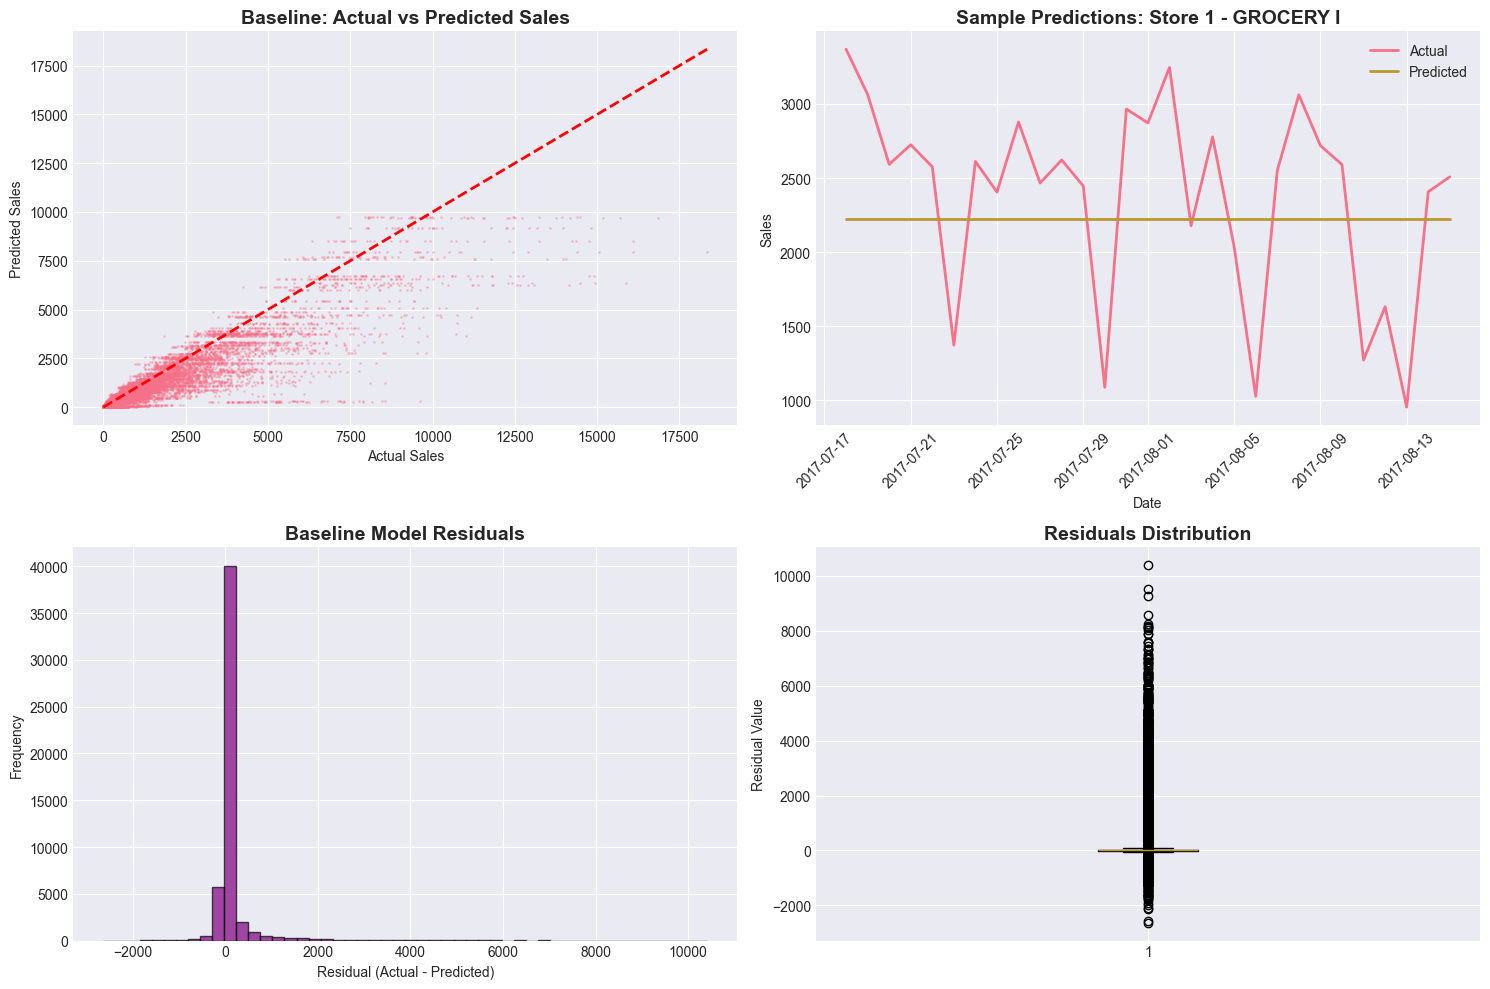

In [18]:
# Visualize actual vs predicted sales for the baseline model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Scatter plot of actual vs predicted sales
axes[0, 0].scatter(val_with_baseline['sales'], val_with_baseline['baseline_pred'], 
                   alpha=0.3, s=1)
axes[0, 0].plot([0, val_with_baseline['sales'].max()], 
                [0, val_with_baseline['sales'].max()], 
                'r--', linewidth=2)  # reference line y=x
axes[0, 0].set_title('Baseline: Actual vs Predicted Sales', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')

# Plot 2: Time series of actual vs predicted for a sample store-family
sample = val_with_baseline[(val_with_baseline['store_nbr'] == 1) & 
                           (val_with_baseline['family'] == 'GROCERY I')]
axes[0, 1].plot(sample['date'], sample['sales'], label='Actual', linewidth=2)
axes[0, 1].plot(sample['date'], sample['baseline_pred'], label='Predicted', linewidth=2)
axes[0, 1].set_title('Sample Predictions: Store 1 - GROCERY I', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Histogram of residuals (Actual - Predicted)
residuals = val_with_baseline['sales'] - val_with_baseline['baseline_pred']
axes[1, 0].hist(residuals, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Baseline Model Residuals', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Residual (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Boxplot of residuals to show distribution and outliers
axes[1, 1].boxplot([residuals])
axes[1, 1].set_title('Residuals Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Residual Value')

# Adjust layout and save figure
plt.tight_layout()
plt.savefig('Results/baseline_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# Install lightgbm and import

import lightgbm as lgb
from sklearn.metrics import mean_squared_error


In [20]:
# Define the features to be used for modeling

# Base features: store info, promotions, oil price, holidays, transactions, and time features
feature_cols = ['store_nbr', 'onpromotion', 'dcoilwtico', 'is_holiday', 
                'transactions', 'year', 'month', 'day', 'day_of_week',
                'day_of_year', 'week_of_year', 'is_weekend', 
                'is_month_start', 'is_month_end']

# Add all lag features to capture past sales patterns
feature_cols.extend([f'sales_lag_{lag}' for lag in [1, 2, 3, 7, 14, 21, 28, 35, 42]])

# Add rolling mean and standard deviation features to capture short- and medium-term trends
feature_cols.extend([f'sales_rolling_mean_{w}' for w in [3, 7, 14, 21, 28]])
feature_cols.extend([f'sales_rolling_std_{w}' for w in [3, 7, 14, 21, 28]])

# Add Exponentially Weighted Moving Average (EWMA) features for smoothed trends
feature_cols.extend([f'sales_ewm_{span}' for span in [7, 14, 28]])

# Add promotion-related features (lags and rolling sums)
feature_cols.extend(['promo_lag_7', 'promo_lag_14', 'promo_rolling_sum_7', 'promo_rolling_sum_28'])

# Add statistical trend features (differences between lagged sales)
feature_cols.extend(['sales_trend_7_14', 'sales_trend_14_28'])

# Add encoded categorical features for modeling
feature_cols.extend(['family_encoded', 'city_encoded', 'state_encoded', 
                     'type_encoded', 'cluster'])

# Print total number of features
print(f"Total features: {len(feature_cols)}")


Total features: 47


In [21]:
# Prepare feature matrices (X) and target vectors (y) for training and validation

# Select feature columns for training data
X_train = train_data[feature_cols]
# Select target variable for training
y_train = train_data['sales']

# Select feature columns for validation data
X_val = val_data[feature_cols]
# Select target variable for validation
y_val = val_data['sales']

# Display the shape of training and validation feature sets
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")


Training features shape: (2949210, 47)
Validation features shape: (51678, 47)


In [22]:
# Train LightGBM model
print("Training LightGBM model...")

# LightGBM hyperparameters
lgb_params = {
    'objective': 'regression',   # regression task
    'metric': 'rmse',            # evaluation metric
    'boosting_type': 'gbdt',     # standard gradient boosting
    'num_leaves': 31,            # controls model complexity
    'learning_rate': 0.05,       # step size shrinkage
    'feature_fraction': 0.8,     # randomly select features per tree
    'bagging_fraction': 0.8,     # subsample data to reduce overfitting
    'bagging_freq': 5,           # perform bagging every 5 iterations
    'verbose': -1,
    'n_jobs': -1                 # use all CPU cores
}

# Convert data into LightGBM datasets
train_dataset = lgb.Dataset(X_train, y_train)
val_dataset = lgb.Dataset(X_val, y_val, reference=train_dataset)

# Train model with early stopping and progress logs
lgb_model = lgb.train(
    lgb_params,
    train_dataset,
    num_boost_round=500,                # maximum boosting rounds
    valid_sets=[train_dataset, val_dataset], 
    valid_names=['train', 'valid'],     # names for printed evaluation
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # stop if no improvement
        lgb.log_evaluation(period=50)            # print logs every 50 rounds
    ]
)

print("\nModel training completed!")


Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 267.092	valid's rmse: 227.442
[100]	train's rmse: 231.169	valid's rmse: 205.921
[150]	train's rmse: 220.375	valid's rmse: 202.534
[200]	train's rmse: 212.749	valid's rmse: 200.849
[250]	train's rmse: 207.086	valid's rmse: 198.569
[300]	train's rmse: 202.03	valid's rmse: 196.735
[350]	train's rmse: 197.581	valid's rmse: 194.669
[400]	train's rmse: 193.969	valid's rmse: 192.811
[450]	train's rmse: 190.808	valid's rmse: 191.78
[500]	train's rmse: 187.706	valid's rmse: 190.394
Did not meet early stopping. Best iteration is:
[500]	train's rmse: 187.706	valid's rmse: 190.394

Model training completed!


In [23]:
# Make predictions on the validation set
val_predictions = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# Ensure predictions are not negative (sales can't be < 0)
val_predictions = np.clip(val_predictions, 0, None)

# Compute RMSLE for validation
lgb_rmsle = rmsle(y_val, val_predictions)

# Display results
print("\n=== LIGHTGBM MODEL RESULTS ===")
print(f"Validation RMSLE: {lgb_rmsle:.4f}")
print(f"Baseline RMSLE: {baseline_rmsle:.4f}")
print(f"Improvement: {(baseline_rmsle - lgb_rmsle) / baseline_rmsle * 100:.2f}%")



=== LIGHTGBM MODEL RESULTS ===
Validation RMSLE: 0.6212
Baseline RMSLE: 0.6876
Improvement: 9.65%


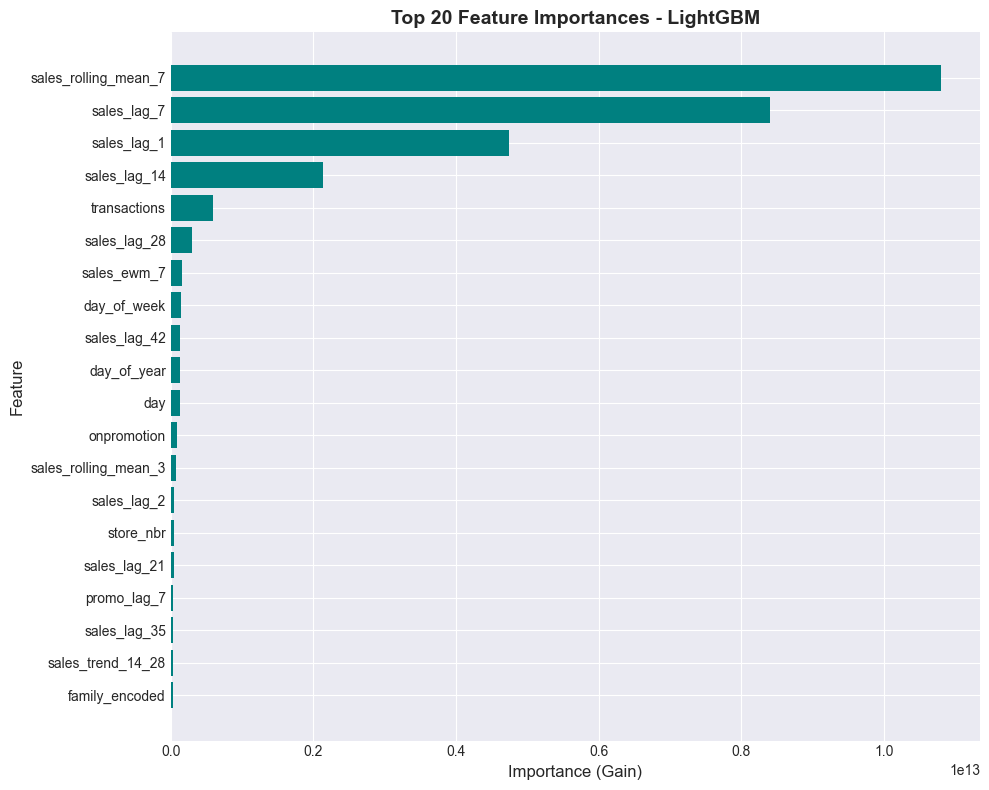


Top 10 Most Important Features:
                 feature    importance
24  sales_rolling_mean_7  1.081071e+13
17           sales_lag_7  8.399577e+12
14           sales_lag_1  4.737978e+12
18          sales_lag_14  2.141970e+12
4           transactions  5.861233e+11
20          sales_lag_28  2.991358e+11
33           sales_ewm_7  1.558285e+11
8            day_of_week  1.494629e+11
22          sales_lag_42  1.347909e+11
9            day_of_year  1.309981e+11


In [24]:
# Compute feature importance (gain-based)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance['feature'].head(20),
    feature_importance['importance'].head(20),
    color='teal'
)
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importances - LightGBM', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()

# Save figure with better naming
plt.savefig('Results/lightgbm_feature_importance.png', dpi=300, bbox_inches='tight')

plt.show()

# Print top features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


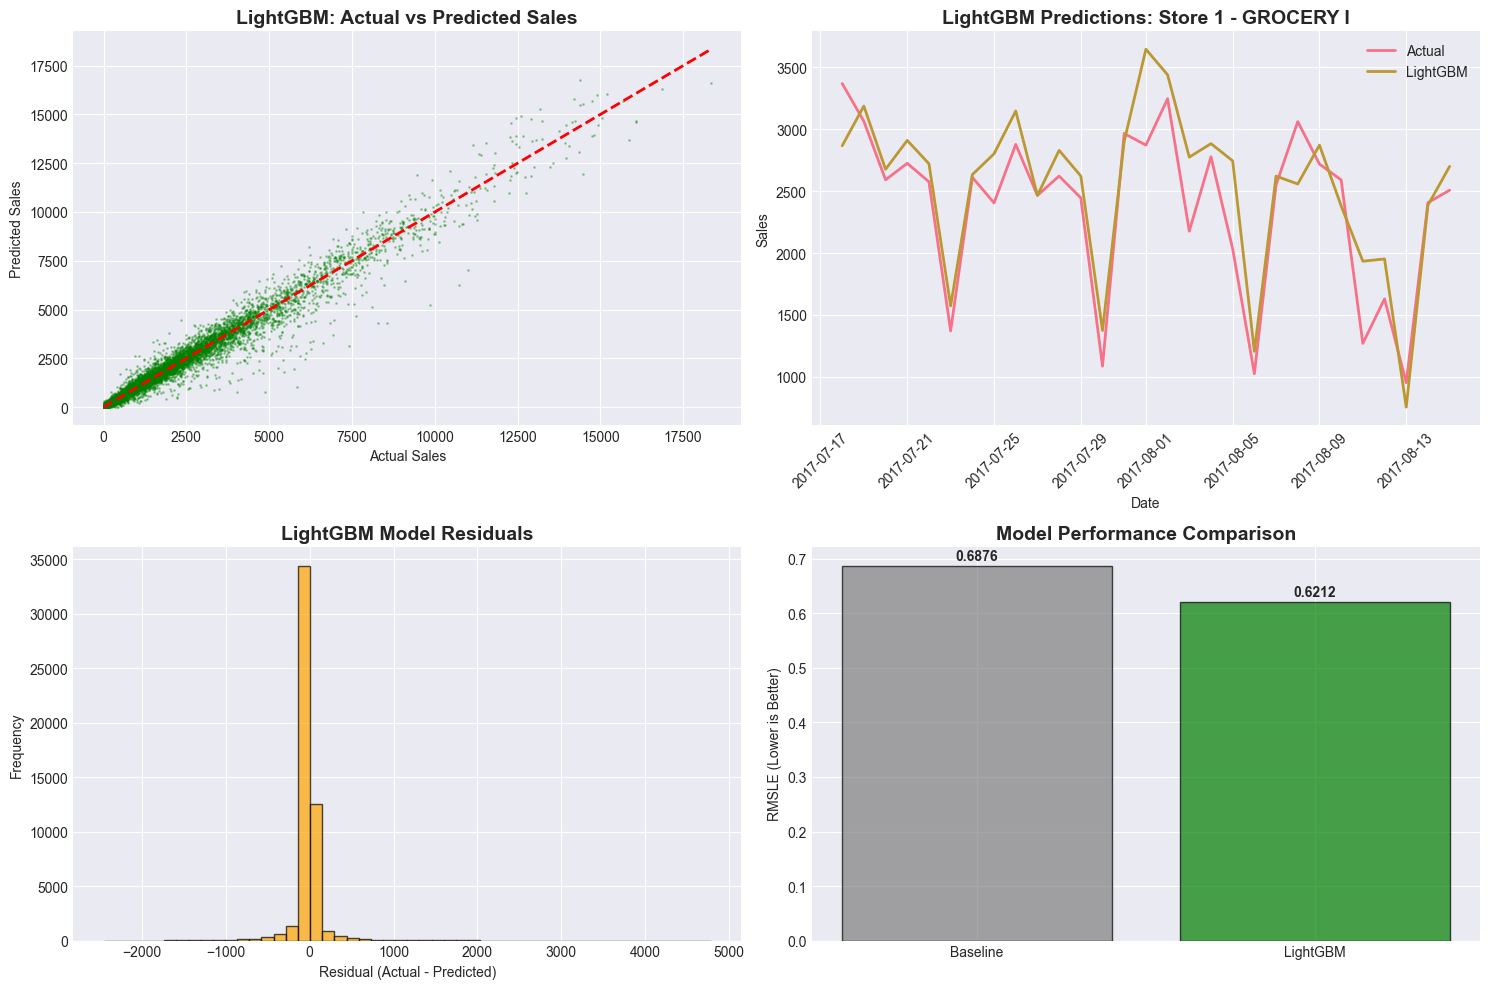

In [25]:
# Visualize LightGBM predictions
val_data_with_pred = val_data.copy()
val_data_with_pred['lgb_pred'] = val_predictions  # Add predictions to validation set

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Plot 1: Actual vs Predicted (Scatter Plot) ---
# Helps you see how close predictions are to real values
axes[0, 0].scatter(val_data_with_pred['sales'], val_data_with_pred['lgb_pred'], 
                   alpha=0.3, s=1, color='green')
axes[0, 0].plot([0, val_data_with_pred['sales'].max()], 
                [0, val_data_with_pred['sales'].max()], 
                'r--', linewidth=2)  # Ideal diagonal line
axes[0, 0].set_title('LightGBM: Actual vs Predicted Sales', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')

# --- Plot 2: Time Series Comparison for One Store-Family ---
# Shows how the model tracks real sales over time
sample = val_data_with_pred[
    (val_data_with_pred['store_nbr'] == 1) & 
    (val_data_with_pred['family'] == 'GROCERY I')
]
axes[0, 1].plot(sample['date'], sample['sales'], label='Actual', linewidth=2)
axes[0, 1].plot(sample['date'], sample['lgb_pred'], label='LightGBM', linewidth=2)
axes[0, 1].set_title('LightGBM Predictions: Store 1 - GROCERY I', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Plot 3: Residuals Histogram ---
# Residual = Actual - Predicted
# Shows error distribution
lgb_residuals = val_data_with_pred['sales'] - val_data_with_pred['lgb_pred']
axes[1, 0].hist(lgb_residuals, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('LightGBM Model Residuals', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Residual (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')

# --- Plot 4: Baseline vs LightGBM RMSLE ---
# Shows which model performs better
metrics_data = pd.DataFrame({
    'Model': ['Baseline', 'LightGBM'],
    'RMSLE': [baseline_rmsle, lgb_rmsle]
})
axes[1, 1].bar(metrics_data['Model'], metrics_data['RMSLE'], 
               color=['gray', 'green'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('RMSLE (Lower is Better)')

# Add labels above bars
for i, v in enumerate(metrics_data['RMSLE']):
    axes[1, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Save final figure
plt.tight_layout()
plt.savefig('Results/lightgbm_predictions_overview.png', dpi=300, bbox_inches='tight')
plt.show()


In [26]:
# Hyperparameter tuning for LightGBM
print("Running hyperparameter tuning...")

# Parameter grid to try different model settings
# We loop over all combinations of these values
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],   # Smaller = slower but more accurate
    'num_leaves': [31, 50, 70],           # Controls model complexity
    'max_depth': [5, 7, 10]               # Max depth of tree (limits overfitting)
}

best_params = None
best_score = float('inf')   # Start with huge score so any model will beat it
tuning_results = []          # Store all runs for later comparison

# Try every combination of learning_rate, num_leaves, and max_depth
for lr in param_grid['learning_rate']:
    for leaves in param_grid['num_leaves']:
        for depth in param_grid['max_depth']:
            
            # Build current parameter set
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'num_leaves': leaves,
                'max_depth': depth,
                'learning_rate': lr,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'n_jobs': -1
            }
            
            # Train model with the current hyperparameters
            model = lgb.train(
                params,
                train_dataset,
                num_boost_round=200,                      # Max number of trees
                valid_sets=[val_dataset],                 # Validate on val set
                callbacks=[lgb.early_stopping(30)]        # Stop early if no improvement
            )
            
            # Make predictions on validation set
            preds = model.predict(X_val, num_iteration=model.best_iteration)
            preds = np.clip(preds, 0, None)               # No negative sales
            
            # Compute RMSLE score
            score = rmsle(y_val, preds)
            
            # Save the result of this trial
            tuning_results.append({
                'learning_rate': lr,
                'num_leaves': leaves,
                'max_depth': depth,
                'rmsle': score
            })
            
            # Track the best model so far
            if score < best_score:
                best_score = score
                best_params = params.copy()
            
            print(f"LR: {lr}, Leaves: {leaves}, Depth: {depth} -> RMSLE: {score:.4f}")

# Display the best hyperparameters found
print(f"\n=== BEST PARAMETERS ===")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Num Leaves: {best_params['num_leaves']}")
print(f"Max Depth: {best_params['max_depth']}")
print(f"Best Validation RMSLE: {best_score:.4f}")


Running hyperparameter tuning...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 265.582
LR: 0.01, Leaves: 31, Depth: 5 -> RMSLE: 1.9954
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 263.54
LR: 0.01, Leaves: 31, Depth: 7 -> RMSLE: 2.0203
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 263.386
LR: 0.01, Leaves: 31, Depth: 10 -> RMSLE: 2.0218
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 265.677
LR: 0.01, Leaves: 50, Depth: 5 -> RMSLE: 1.9920
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 259.154
LR: 0.01, Leaves: 50, Depth: 7 -> RMSLE: 2.0084
Training until validation scores

In [27]:
# Train final tuned model using the best hyperparameters
print("\nTraining final tuned LightGBM model...")

tuned_model = lgb.train(
    best_params,                 # best combination of hyperparameters found earlier
    train_dataset,               # training data for boosting
    num_boost_round=500,         # maximum number of boosting rounds
    valid_sets=[train_dataset, val_dataset],   # track training & validation performance
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]  
    # stop early if validation score doesn't improve after 50 rounds
)

# Predict on the validation set using the best iteration from training
tuned_predictions = tuned_model.predict(
    X_val,
    num_iteration=tuned_model.best_iteration
)

# LightGBM may output small negative values; RMSLE can't handle negatives.
tuned_predictions = np.clip(tuned_predictions, 0, None)

# Calculate RMSLE to measure model performance
tuned_rmsle = rmsle(y_val, tuned_predictions)

print(f"Tuned Model RMSLE: {tuned_rmsle:.4f}")



Training final tuned LightGBM model...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	train's rmse: 152.048	valid's rmse: 184.253
Tuned Model RMSLE: 0.5464


In [28]:
# Optional: Train a simple linear model (Ridge Regression)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

print("\nTraining Ridge Regression model...")

# Scale the features so linear model performs better
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train the Ridge Regression model with L2 regularization
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on validation set
ridge_predictions = ridge_model.predict(X_val_scaled)

# Clip negative predictions because RMSLE cannot handle negatives
ridge_predictions = np.clip(ridge_predictions, 0, None)

# Calculate RMSLE to evaluate performance
ridge_rmsle = rmsle(y_val, ridge_predictions)

print(f"Ridge Model RMSLE: {ridge_rmsle:.4f}")



Training Ridge Regression model...
Ridge Model RMSLE: 1.1780



=== MODEL COMPARISON ===
              Model    RMSLE
   LightGBM (Tuned) 0.546382
LightGBM (Original) 0.621224
           Baseline 0.687564
   Ridge Regression 1.177952


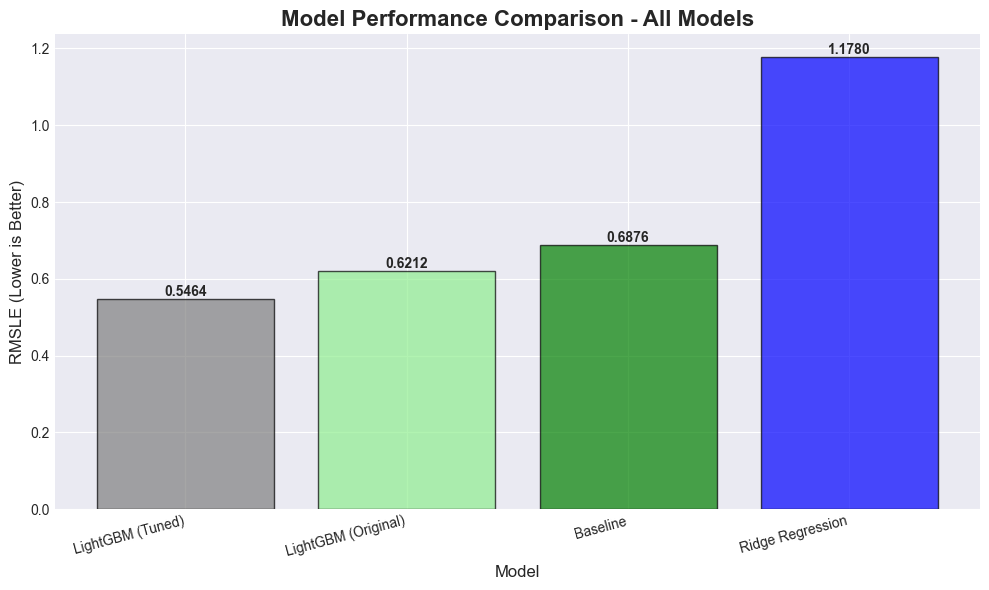


*** Best Model: LightGBM (Tuned) with RMSLE: 0.5464 ***


In [29]:
# Compare all models using RMSLE
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'LightGBM (Original)', 'LightGBM (Tuned)', 'Ridge Regression'],
    'RMSLE': [baseline_rmsle, lgb_rmsle, tuned_rmsle, ridge_rmsle]
}).sort_values('RMSLE')

# Print comparison table
print("\n=== MODEL COMPARISON ===")
print(comparison_df.to_string(index=False))

# Visualize model performance comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Model'], comparison_df['RMSLE'], 
               color=['gray', 'lightgreen', 'green', 'blue'], 
               alpha=0.7, edgecolor='black')
plt.title('Model Performance Comparison - All Models', fontsize=16, fontweight='bold')
plt.ylabel('RMSLE (Lower is Better)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15, ha='right')

# Add RMSLE values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('Results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify and print the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_score = comparison_df.iloc[0]['RMSLE']
print(f"\n*** Best Model: {best_model_name} with RMSLE: {best_model_score:.4f} ***")


In [30]:
# Prepare test data with proper historical context
print("Preparing test data with proper historical context...")

# Load and merge test data with stores, oil, holidays, and transactions
test_df = test.copy()
test_df = test_df.merge(stores, on='store_nbr', how='left')
test_df = test_df.merge(oil, on='date', how='left')
test_df = test_df.merge(holidays[['date', 'is_holiday']].drop_duplicates(), on='date', how='left')
test_df['is_holiday'] = test_df['is_holiday'].fillna(0)
test_df = test_df.merge(transactions, on=['date', 'store_nbr'], how='left')

# Create time-based features
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['day_of_year'] = test_df['date'].dt.dayofyear
test_df['week_of_year'] = test_df['date'].dt.isocalendar().week
test_df['is_weekend'] = (test_df['day_of_week'] >= 5).astype(int)
test_df['is_month_start'] = test_df['date'].dt.is_month_start.astype(int)
test_df['is_month_end'] = test_df['date'].dt.is_month_end.astype(int)

# Encode categorical features
test_df['family_encoded'] = test_df['family'].astype('category').cat.codes
test_df['city_encoded'] = test_df['city'].astype('category').cat.codes
test_df['state_encoded'] = test_df['state'].astype('category').cat.codes
test_df['type_encoded'] = test_df['type'].astype('category').cat.codes

# Combine train and test for proper lag feature computation
train_for_lags = df[['date', 'store_nbr', 'family', 'sales', 'onpromotion']].copy()
test_for_lags = test_df[['date', 'store_nbr', 'family', 'onpromotion']].copy()
test_for_lags['sales'] = np.nan  # sales unknown for test

combined = pd.concat([train_for_lags, test_for_lags], ignore_index=True)
combined = combined.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# Create lag features
for lag in [1, 2, 3, 7, 14, 21, 28, 35, 42]:
    combined[f'sales_lag_{lag}'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# Create rolling mean and std features
for window in [3, 7, 14, 21, 28]:
    combined[f'sales_rolling_mean_{window}'] = combined.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    combined[f'sales_rolling_std_{window}'] = combined.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )

# Create EWMA features
for span in [7, 14, 28]:
    combined[f'sales_ewm_{span}'] = combined.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).ewm(span=span, min_periods=1).mean()
    )

# Create promotion lag features
for lag in [7, 14]:
    combined[f'promo_lag_{lag}'] = combined.groupby(['store_nbr', 'family'])['onpromotion'].shift(lag)

# Create promotion rolling sum features
for window in [7, 28]:
    combined[f'promo_rolling_sum_{window}'] = combined.groupby(['store_nbr', 'family'])['onpromotion'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).sum()
    )

# Create statistical trend features
combined['sales_trend_7_14'] = combined['sales_lag_7'] - combined['sales_lag_14']
combined['sales_trend_14_28'] = combined['sales_lag_14'] - combined['sales_lag_28']

# Extract only the test portion with features
test_dates = test_df['date'].unique()
test_with_features = combined[combined['date'].isin(test_dates)].copy()

# Define all lag, rolling, EWMA, promotion, and trend features
feature_cols_to_merge = []
feature_cols_to_merge.extend([f'sales_lag_{lag}' for lag in [1, 2, 3, 7, 14, 21, 28, 35, 42]])
feature_cols_to_merge.extend([f'sales_rolling_mean_{w}' for w in [3, 7, 14, 21, 28]])
feature_cols_to_merge.extend([f'sales_rolling_std_{w}' for w in [3, 7, 14, 21, 28]])
feature_cols_to_merge.extend([f'sales_ewm_{span}' for span in [7, 14, 28]])
feature_cols_to_merge.extend(['promo_lag_7', 'promo_lag_14', 'promo_rolling_sum_7', 'promo_rolling_sum_28'])
feature_cols_to_merge.extend(['sales_trend_7_14', 'sales_trend_14_28'])

# Merge computed features back to test dataframe
test_df = test_df.merge(
    test_with_features[['date', 'store_nbr', 'family'] + feature_cols_to_merge],
    on=['date', 'store_nbr', 'family'],
    how='left'
)

# Fill any missing values for lag, rolling, EWMA, promo, and trend features
test_df[feature_cols_to_merge] = test_df[feature_cols_to_merge].fillna(0)

# Fill remaining missing values for other features
test_df['dcoilwtico'] = test_df['dcoilwtico'].fillna(test_df['dcoilwtico'].median())
test_df['transactions'] = test_df['transactions'].fillna(0)

print(f"\nTest data prepared correctly: {test_df.shape}")
print(f"Total columns in test data: {len(test_df.columns)}")

# Verify lag features
print("\nLag feature statistics for verification:")
print(test_df[['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28']].describe())

# Verify that all features are present
missing_features = [col for col in feature_cols if col not in test_df.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All features present in test data")

# Show sample lag values to verify variation across store-family
print("\nSample test data lag features:")
print(test_df[['store_nbr', 'family', 'sales_lag_7', 'sales_ewm_7', 'promo_lag_7']].head(20))


Preparing test data with proper historical context...

Test data prepared correctly: (28512, 53)
Total columns in test data: 53

Lag feature statistics for verification:
        sales_lag_1   sales_lag_7  sales_lag_14  sales_lag_28
count  28512.000000  28512.000000  28512.000000  28512.000000
mean      26.748805    189.174904    401.402749    479.968185
std      290.457720    788.262730   1160.623210   1306.085399
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      3.000000
50%        0.000000      0.000000     17.000000     29.000000
75%        0.000000     17.000000    213.000000    279.000000
max     9389.000000  12723.000000  15190.000000  18340.000000
All features present in test data

Sample test data lag features:
    store_nbr               family  sales_lag_7  sales_ewm_7  promo_lag_7
0           1           AUTOMOTIVE        7.000     3.599009          0.0
1           1            BABY CARE        0.000     0.0000

In [31]:
# Train final LightGBM model on the full dataset
print("Training final model on full dataset...")

# Prepare features and target for the full dataset
X_full = df[feature_cols]
y_full = df['sales']

# Create LightGBM dataset
full_dataset = lgb.Dataset(X_full, y_full)

# Train final model using best hyperparameters and tuned iteration count
final_model = lgb.train(
    best_params,
    full_dataset,
    num_boost_round=tuned_model.best_iteration
)

print("Final model trained on full dataset!")


Training final model on full dataset...
Final model trained on full dataset!


In [32]:
# Make predictions on the test set using the final model
print("Making predictions on test data...")

# Prepare test features
X_test = test_df[feature_cols]

# Predict sales
test_predictions = final_model.predict(X_test)
test_predictions = np.clip(test_predictions, 0, None)  # Ensure no negative predictions

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'sales': test_predictions
})

# Save submission to CSV
submission.to_csv('Data/submission.csv', index=False)

print(f"Submission file created with {len(submission)} predictions")
print(submission.head(10))


Making predictions on test data...
Submission file created with 28512 predictions
        id        sales
0  3000888     0.000000
1  3000889     0.000000
2  3000890     0.000000
3  3000891  1247.721145
4  3000892     0.000000
5  3000893   244.852823
6  3000894     0.000000
7  3000895   462.450804
8  3000896   420.129053
9  3000897    94.077101


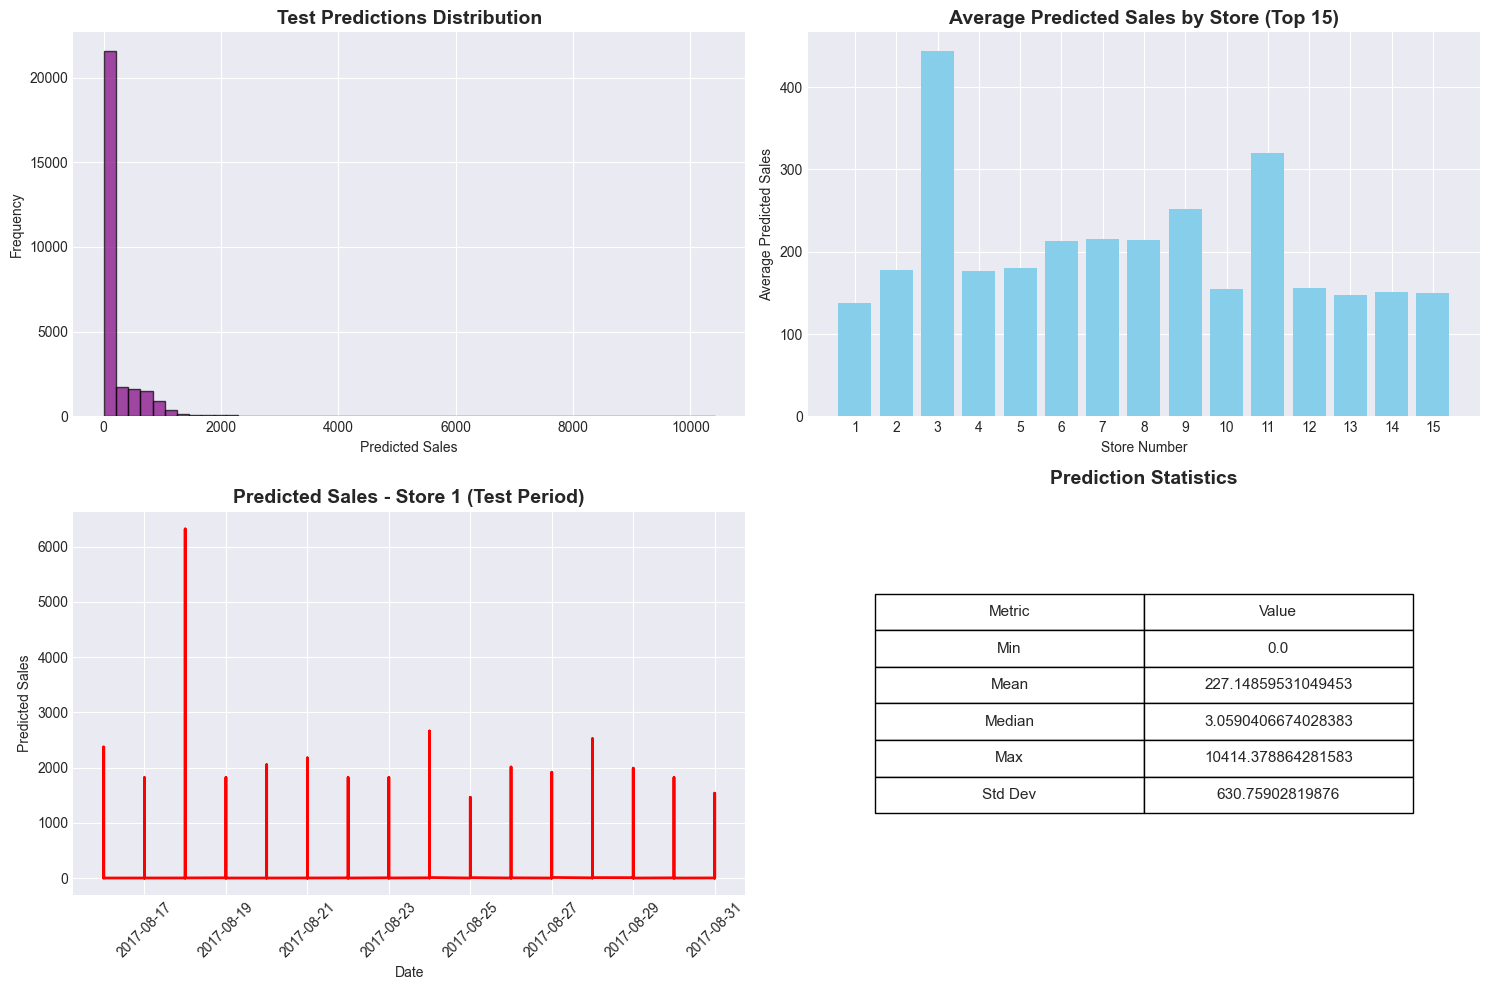

In [33]:
# Create a 2x2 grid of subplots to visualize test predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Histogram of predicted sales for the test set
axes[0, 0].hist(test_predictions, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Test Predictions Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Sales')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: Average predicted sales by store (Top 15 stores)
store_preds = submission.merge(test_df[['id', 'store_nbr']], on='id')
store_avg = store_preds.groupby('store_nbr')['sales'].mean().head(15)
axes[0, 1].bar(store_avg.index.astype(str), store_avg.values, color='skyblue')
axes[0, 1].set_title('Average Predicted Sales by Store (Top 15)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Store Number')
axes[0, 1].set_ylabel('Average Predicted Sales')

# Plot 3: Predicted sales over time for a sample store (store 1)
sample_store = test_df[test_df['store_nbr'] == 1].copy()
sample_store['prediction'] = test_predictions[:len(sample_store)]  # Align predictions
axes[1, 0].plot(sample_store['date'], sample_store['prediction'], linewidth=2, color='red')
axes[1, 0].set_title('Predicted Sales - Store 1 (Test Period)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Predicted Sales')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Summary statistics table for test predictions
summary_stats = pd.DataFrame({
    'Metric': ['Min', 'Mean', 'Median', 'Max', 'Std Dev'],
    'Value': [
        test_predictions.min(),
        test_predictions.mean(),
        np.median(test_predictions),
        test_predictions.max(),
        test_predictions.std()
    ]
})
axes[1, 1].axis('tight')  # Remove axes for table
axes[1, 1].axis('off')
table = axes[1, 1].table(
    cellText=summary_stats.values,
    colLabels=summary_stats.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.4]
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)
axes[1, 1].set_title('Prediction Statistics', fontsize=14, fontweight='bold', pad=20)

# Adjust layout, save figure, and display
plt.tight_layout()
plt.savefig('Results/final_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
